# Import packages

In [4]:
from py3dbp import Packer, Bin, Item

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# First step, get a maximum estimate for the potential box size

In [5]:
def calculate_box_dimensions(items):
    """
    Calculate dimensions for a box to fit all given items.
    
    Parameters:
    items (dict): A dictionary of items with their dimensions and weights.
    
    Returns:
    tuple: Suggested dimensions for the box (width, height, depth).
    """
    # Initialize sums and maximums
    sum_width = sum(item['width'] for item in items.values())
    sum_height = sum(item['height'] for item in items.values())
    sum_depth = sum(item['depth'] for item in items.values())
    max_width = max(item['width'] for item in items.values())
    max_height = max(item['height'] for item in items.values())
    max_depth = max(item['depth'] for item in items.values())

    # Box dimensions based on the sum of dimensions and maximums
    box_width = max(sum_width, max_width)
    box_height = max(sum_height, max_height)
    box_depth = max(sum_depth, max_depth)

    return box_width, box_height, box_depth

# Example usage with your provided items
items_example = {
    'item_1': {'item_no': 1, 'width': 6, 'height': 10, 'depth': 3, 'weight': 0},
    'item_2': {'item_no': 2, 'width': 30, 'height': 9, 'depth': 5, 'weight': 0},
    'item_3': {'item_no': 3, 'width': 10, 'height': 15, 'depth': 24, 'weight': 0},
    'item_4': {'item_no': 4, 'width': 12, 'height': 3, 'depth': 28, 'weight': 0},
    'item_5': {'item_no': 5, 'width': 28, 'height': 6, 'depth': 20, 'weight': 0}
}

# Call the function
box_dimensions = calculate_box_dimensions(items_example)
box_dimensions


(86, 43, 80)

# Potentially find a better initial guess incorporating the volume and a wiggle factor

In [6]:
def refined_estimate_box_dimensions(items, inefficiency_factor=1.2):
    """
    Calculate a refined estimate of box dimensions to fit all items.
    
    Parameters:
    - items (dict): Dictionary of items with dimensions.
    - inefficiency_factor (float): Factor to adjust for packing inefficiency (default 1.2).
    
    Returns:
    - tuple: Estimated dimensions for the box (width, height, depth).
    """
    # Calculate total volume and maximum dimensions
    total_volume = sum(item['width'] * item['height'] * item['depth'] for item in items.values())
    max_width = max(item['width'] for item in items.values())
    max_height = max(item['height'] for item in items.values())
    max_depth = max(item['depth'] for item in items.values())
    
    # Calculate volume-based cubic dimensions and adjust for inefficiency
    cubic_side = (total_volume ** (1/3)) * inefficiency_factor
    estimated_width = max(cubic_side, max_width)
    estimated_height = max(cubic_side, max_height)
    estimated_depth = max(cubic_side, max_depth)

    return estimated_width, estimated_height, estimated_depth

box_dimensions = refined_estimate_box_dimensions(items_example)
box_dimensions

(30, 25.413157875689436, 28)

In [11]:
def find_optimal_bin_dimensions(items, start_size, step=1, inefficiency_factor=1.1):
    """
    Find the smallest bin dimensions that can fit all items.
    
    Parameters:
    - items (dict): Dictionary of items with their dimensions and weights.
    - start_size (tuple): Starting bin dimensions (width, height, depth).
    - step (float): Adjustment step size for bin dimensions.
    - inefficiency_factor (float): Adjustment factor for reducing dimensions on success.
    
    Returns:
    - tuple: Optimal bin dimensions (width, height, depth).
    """
    # Unpack starting size
    width, height, depth = start_size
    all_fit = True

    # Attempt to pack with decreasing sizes until not all items fit
    while all_fit:
        # Initialize packer and bin
        packer = Packer()
        bin = Bin("Bin1", width, height, depth, 0)
        packer.add_bin(bin)
        
        # Add items
        for name, dims in items.items():
            packer.add_item(Item(name, dims['width'], dims['height'], dims['depth'], dims['weight']))
        
        # Attempt packing
        packer.pack()
        
        # Check if all items were packed
        items_packed = sum(len(bin.items) for bin in packer.bins)
    
        # Compare to the number of items attempted to pack
        all_items_packed = items_packed == len(items)
        
        if all_items_packed:
            print(1)
            width *= inefficiency_factor
            height *= inefficiency_factor
            depth *= inefficiency_factor
              # Indicates successful packing
        else:
            print(2)
            all_fit = False

    # May need to adjust to last successful dimensions if last attempt failed
    return width / inefficiency_factor, height / inefficiency_factor, depth / inefficiency_factor

# Usage example
items_example = {
    'item_1': {'item_no': 1, 'width': 20, 'height': 10, 'depth': 3, 'weight': 0},
    'item_2': {'item_no': 2, 'width': 30, 'height': 9, 'depth': 5, 'weight': 0},
    'item_3': {'item_no': 3, 'width': 10, 'height': 15, 'depth': 24, 'weight': 0},
    'item_4': {'item_no': 4, 'width': 12, 'height': 3, 'depth': 28, 'weight': 0},
}
start_size = refined_estimate_box_dimensions(items_example)  # Get starting size estimate
optimal_dimensions = find_optimal_bin_dimensions(items_example, start_size)
print(f"Optimal bin dimensions: {optimal_dimensions}")

2
Optimal bin dimensions: (27.27272727272727, 20.419527964238394, 25.454545454545453)


In [18]:
def visualize_packing(bin, items):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Bin dimensions
    bin_width, bin_height, bin_depth = bin.width, bin.height, bin.depth
    ax.bar3d(0, 0, 0, bin_width, bin_height, bin_depth, alpha=0.1, color='blue', linewidth=0.5)

    colors = ['red', 'green', 'blue', 'orange', 'purple']

    for i, item in enumerate(items):
        # Item dimensions and position
        w, h, d = item.width, item.height, item.depth
        x, y, z = item.position

        # Adjust position based on the item's orientation
        ax.bar3d(x, y, z, w, h, d, alpha=0.5, color=colors[i % len(colors)], linewidth=0.5)

    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')
    plt.show()

# After running packer.pack(), call this function with the bin and items
# Assume 'bin' is the first bin in packer.bins
# And 'items' are the items in the first bin
# visualize_packing(bin, bin.items)



In [21]:
def setup_and_pack_items(items):
    # Calculate box dimensions as done previously
    # sum_width, sum_height, sum_depth = calculate_box_dimensions(items)
    # sum_width, sum_height, sum_depth = refined_estimate_box_dimensions(items)
    sum_width, sum_height, sum_depth = find_optimal_bin_dimensions(items,calculate_box_dimensions(items))
    
    
    print(sum_width)
    # Create a bin with these dimensions
    bin = Bin("Bin1", sum_width, sum_height, sum_depth, 0)  # Assuming weight limit is not a concern here

    # Initialize the packer
    packer = Packer()

    # Add the bin
    packer.add_bin(bin)

    # Add items to the packer
    for key, item in items.items():
        packer.add_item(Item(key, item['width'], item['height'], item['depth'], item['weight']))

    # Run the packer
    packer.pack()

    # Assuming we're working with only one bin for simplicity
    bin_dimensions = {'width': sum_width, 'height': sum_height, 'depth': sum_depth}
    return (packer.bins[0], bin_dimensions)

# Example usage with your provided items
items = {
    'item_1': {'item_no': 1, 'width': 6, 'height': 10, 'depth': 3, 'weight': 0},
    'item_2': {'item_no': 2, 'width': 30, 'height': 9, 'depth': 5, 'weight': 0},
    'item_3': {'item_no': 3, 'width': 10, 'height': 15, 'depth': 24, 'weight': 0},
    'item_4': {'item_no': 4, 'width': 12, 'height': 3, 'depth': 28, 'weight': 0},
    'item_5': {'item_no': 5, 'width': 28, 'height': 6, 'depth': 20, 'weight': 0}
}

setup_and_pack_items(items)

30


(<py3dbp.main.Bin at 0x7fc1d514d300>,
 {'width': 30, 'height': 25.413157875689436, 'depth': 28})

30


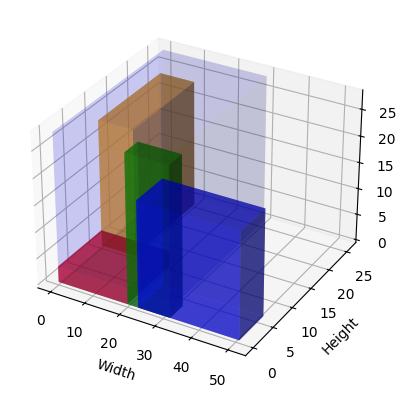

In [22]:
# Example usage
bin, dimensions = setup_and_pack_items(items_example)  # Assuming items_example is your items dictionary
visualize_packing(bin, bin.items)


In [41]:
width, height, depth = start_size

In [42]:
width

30

In [43]:
bin = Bin("Bin1", width, height, depth, 0)

In [52]:
packer = Packer()

# Add the bin
packer.add_bin(bin)

items = {
    'item_1': {'item_no': 1, 'width': 6, 'height': 10, 'depth': 3, 'weight': 0},
    'item_2': {'item_no': 2, 'width': 30, 'height': 9, 'depth': 5, 'weight': 0},
    'item_3': {'item_no': 3, 'width': 10, 'height': 15, 'depth': 24, 'weight': 0},
    'item_4': {'item_no': 4, 'width': 12, 'height': 3, 'depth': 28, 'weight': 0},
    'item_5': {'item_no': 5, 'width': 280, 'height': 66, 'depth': 20, 'weight': 0}
}

In [53]:
# Add items to the packer
for key, item in items.items():
    packer.add_item(Item(key, item['width'], item['height'], item['depth'], item['weight']))

In [54]:
packer.pack()

In [55]:
packer.items

In [56]:
bin_dimensions = {'width': width, 'height': height, 'depth': depth}

In [57]:
packer.bins[0]

280


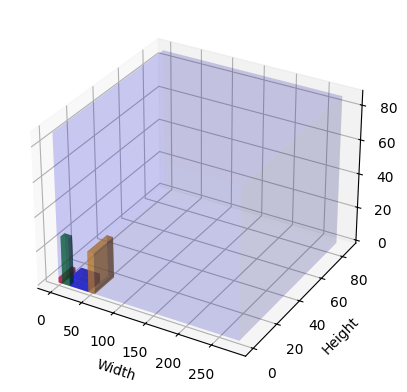

In [58]:
bin, dimensions = setup_and_pack_items(items)  # Assuming items_example is your items dictionary
visualize_packing(bin, bin.items)

In [63]:
from py3dbp import Packer, Bin, Item

def attempt_packing(items, bin_dimensions):
    """
    Attempt to pack given items into a bin with specified dimensions.
    
    Parameters:
    - items (dict): Dictionary of items with dimensions and weight.
    - bin_dimensions (tuple): Dimensions of the bin (width, height, depth).
    
    Returns:
    - bool: True if all items were successfully packed, False otherwise.
    """
    # Unpack bin dimensions
    width, height, depth = bin_dimensions
    
    # Initialize packer and bin
    packer = Packer()
    bin = Bin("Bin1", width, height, depth, 100000)  # Assuming weight limit is not a concern
    packer.add_bin(bin)
    
    # Add items to packer
    for name, dims in items.items():
        packer.add_item(Item(name, dims['width'], dims['height'], dims['depth'], dims['weight']))
    
    # Perform packing
    packer.pack()
    
    # Check if all items were packed
    # Sum the number of items in all bins
    items_packed = sum(len(bin.items) for bin in packer.bins)
    
    # Compare to the number of items attempted to pack
    all_items_packed = items_packed == len(items)
    
    return all_items_packed

# Example usage
items_example = {
    'item_1': {'item_no': 1, 'width': 60, 'height': 10, 'depth': 3, 'weight': 0},
    # Add more items as needed...
}
bin_dimensions = (50, 50, 50)  # Example bin dimensions

all_fit = attempt_packing(items_example, bin_dimensions)
print("All items fit" if all_fit else "Not all items fit.")



Not all items fit.


In [1]:
from py3dbp import Packer, Bin, Item

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

In [2]:
def initial_estimate_dimensions(items):
    total_volume = sum(item['width'] * item['height'] * item['depth'] for item in items.values())
    max_width = max(item['width'] for item in items.values())
    max_height = max(item['height'] for item in items.values())
    max_depth = max(item['depth'] for item in items.values())
    
    volume_side = total_volume ** (1/3)
    return max(max_width, volume_side), max(max_height, volume_side), max(max_depth, volume_side)


In [3]:
def check_all_items_packed(items, bin_dimensions, return_packer=False):
    packer = Packer()
    bin = Bin("Bin", *bin_dimensions, 1000000)  # Large weight capacity
    packer.add_bin(bin)
    
    for name, dims in items.items():
        packer.add_item(Item(name, dims['width'], dims['height'], dims['depth'], 0))  # Weight is set to 0
    
    packer.pack()
    
    if return_packer:
        return sum(len(b.items) for b in packer.bins) == len(items), packer
    else:
        return sum(len(b.items) for b in packer.bins) == len(items)


In [4]:
def visualize_packing(packer):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for bin in packer.bins:
        for item in bin.items:
            # Item bottom corner
            x, y, z = item.position
            dx, dy, dz = item.get_dimension()
            ax.bar3d(x, y, z, dx, dy, dz, alpha=0.5)
    
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    ax.set_zlabel('Depth')
    plt.show()


In [12]:
def find_optimal_bin_dimensions_with_visualization(items, reduce_factor=0.99):
    bin_dimensions = initial_estimate_dimensions(items)
    optimal_found = False
    last_successful_packer = None
    
    while not optimal_found:
        all_fit, packer = check_all_items_packed(items, bin_dimensions, return_packer=True)
        if all_fit:
            # If all items are packed, reduce the bin size
            bin_dimensions = tuple(dim * reduce_factor for dim in bin_dimensions)
            last_successful_packer = packer
        else:
            # If not all items fit, use the last successful dimensions and packer for visualization
            bin_dimensions = tuple(dim / reduce_factor for dim in bin_dimensions)
            optimal_found = True
    
    # Visualize the packing of the last successful attempt
    # if last_successful_packer:
    visualize_packing(last_successful_packer)
    
    return bin_dimensions

In [15]:
items_example = {
    'item_1': {'item_no': 1, 'width': 6, 'height': 10, 'depth': 3, 'weight': 0},
    'item_2': {'item_no': 2, 'width': 30, 'height': 9, 'depth': 5, 'weight': 0},
    'item_3': {'item_no': 3, 'width': 10, 'height': 15, 'depth': 24, 'weight': 0},
}

# optimal_dimensions = find_optimal_bin_dimensions(items_example)
# print(f"Optimal bin dimensions (WxHxD): {optimal_dimensions}")


AttributeError: 'NoneType' object has no attribute 'bins'

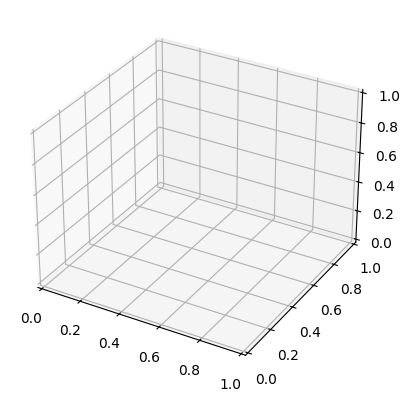

In [16]:
# Example usage
optimal_dimensions = find_optimal_bin_dimensions_with_visualization(items_example)
print(f"Optimal bin dimensions (WxHxD): {optimal_dimensions}")